[Video Link](https://drive.google.com/drive/folders/1Phb_KCA_WvcyThjTxfqN9O-YYIzzmgIw?usp=sharing)<br>
https://drive.google.com/drive/folders/1Phb_KCA_WvcyThjTxfqN9O-YYIzzmgIw?usp=sharing

# Q10
### Read the pytorch tutorial to use a pre-trained “ConvNet as fixed feature extractor” from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html and you can ignore “finetuning the ConvNet”. Test this code out to see if it runs properly in your environment after eliminating code blocks that you do not need

In [ ]:
#import libraries -(a)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

ModuleNotFoundError: No module named 'torch'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/ee353_a3')
!unzip  /content/drive/MyDrive/ee353_a3/hymenoptera_data.zip -d data
#

In [6]:
#Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/ee353_a3/data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

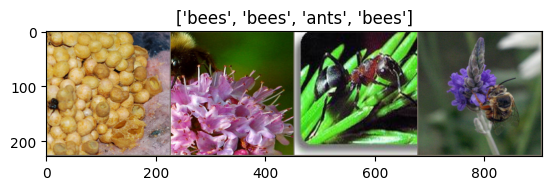

In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
#load the ResNet18 model
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


In [11]:
#training
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.6462 Acc: 0.6352
val Loss: 0.4710 Acc: 0.8039

Epoch 1/29
----------
train Loss: 0.5468 Acc: 0.7910
val Loss: 0.2364 Acc: 0.8954

Epoch 2/29
----------
train Loss: 0.4616 Acc: 0.7992
val Loss: 0.3876 Acc: 0.8889

Epoch 3/29
----------
train Loss: 0.6563 Acc: 0.7828
val Loss: 0.5025 Acc: 0.8235

Epoch 4/29
----------
train Loss: 0.5604 Acc: 0.7869
val Loss: 0.2778 Acc: 0.9085

Epoch 5/29
----------
train Loss: 0.4941 Acc: 0.7951
val Loss: 0.2811 Acc: 0.8889

Epoch 6/29
----------
train Loss: 0.6054 Acc: 0.7910
val Loss: 0.4871 Acc: 0.8301

Epoch 7/29
----------
train Loss: 0.4302 Acc: 0.8361
val Loss: 0.3193 Acc: 0.8693

Epoch 8/29
----------
train Loss: 0.3571 Acc: 0.8484
val Loss: 0.2415 Acc: 0.9020

Epoch 9/29
----------
train Loss: 0.3090 Acc: 0.8689
val Loss: 0.2248 Acc: 0.9150

Epoch 10/29
----------
train Loss: 0.3135 Acc: 0.8730
val Loss: 0.1799 Acc: 0.9216

Epoch 11/29
----------
train Loss: 0.2002 Acc: 0.9180
val Loss: 0.1911 Acc: 0.9020

Ep

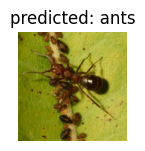

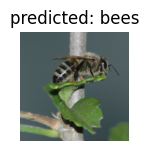

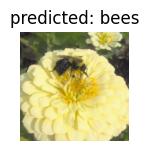

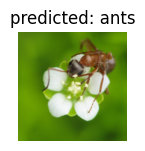

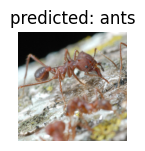

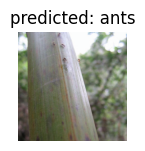

In [12]:
visualize_model(model_ft)

In [13]:
#fixed feature extractor
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Only parameters of final layer are being optimized as opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [14]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.6721 Acc: 0.6230
val Loss: 0.2745 Acc: 0.9085

Epoch 1/29
----------
train Loss: 0.4931 Acc: 0.7582
val Loss: 0.2869 Acc: 0.9020

Epoch 2/29
----------
train Loss: 0.5160 Acc: 0.7828
val Loss: 0.1792 Acc: 0.9412

Epoch 3/29
----------
train Loss: 0.4406 Acc: 0.7992
val Loss: 0.2811 Acc: 0.9020

Epoch 4/29
----------
train Loss: 0.4148 Acc: 0.8033
val Loss: 0.1827 Acc: 0.9412

Epoch 5/29
----------
train Loss: 0.4723 Acc: 0.7746
val Loss: 0.1849 Acc: 0.9346

Epoch 6/29
----------
train Loss: 0.3988 Acc: 0.8320
val Loss: 0.2078 Acc: 0.9216

Epoch 7/29
----------
train Loss: 0.3640 Acc: 0.8115
val Loss: 0.1887 Acc: 0.9346

Epoch 8/29
----------
train Loss: 0.2796 Acc: 0.8934
val Loss: 0.2165 Acc: 0.9216

Epoch 9/29
----------
train Loss: 0.3448 Acc: 0.8648
val Loss: 0.1975 Acc: 0.9412

Epoch 10/29
----------
train Loss: 0.2912 Acc: 0.9016
val Loss: 0.1927 Acc: 0.9346

Epoch 11/29
----------
train Loss: 0.3015 Acc: 0.8607
val Loss: 0.1876 Acc: 0.9412

Ep

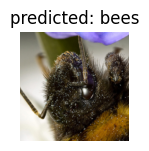

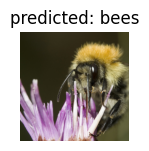

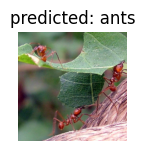

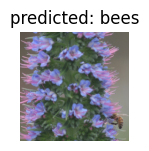

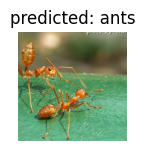

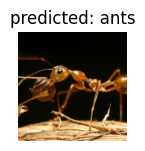

In [15]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [16]:
#inference on individual images
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)


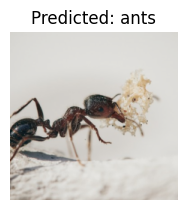

In [17]:
visualize_model_predictions(
    model_conv,
    img_path='/content/ants-5061910_640.jpg'
)

plt.ioff()
plt.show()

**Q11**  Write a function that outputs ResNet18 features for a given input image. Extract features for training images
(in image_datasets['train']). You should get an Nx512 dimensional array

In [ ]:
def extract_image_features(model, image_path, device): #-(b) see citation at the end
    # Define the transformation for the image
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load image
    image = Image.open(image_path).convert('RGB')

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the tensor to the device
    image_tensor = image_tensor.to(device)

    # Extract features
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # here we don't need to do gradient computation
        features = model(image_tensor)
        features = features.squeeze().cpu().numpy()  # Remove batch dimension and convert to numpy

    return features

# Load pre-trained ResNet18 and modify to extract features
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
model_conv = nn.Sequential(*list(model_conv.children())[:-1])  # Remove the fully connected layer
model_conv = model_conv.to(device)

# Example usage
image_path = '/content/ants-5061910_640.jpg'  # Replace with the path to your image
features = extract_image_features(model_conv, image_path, device)
print(f'Extracted features shape: {features.shape}')  # Expected: (512,)


Extracted features shape: (512,)


In [20]:
features

array([1.97104722e-01, 7.76174814e-02, 1.03007722e+00, 8.68525863e-01,
       4.21116877e+00, 1.55535236e-01, 1.45319450e+00, 3.94221842e-01,
       1.07490432e+00, 6.83416069e-01, 5.77511340e-02, 5.16969524e-02,
       8.52111503e-02, 2.10466290e+00, 7.34006584e-01, 4.99887377e-01,
       5.06163001e-01, 3.51968050e+00, 1.29224646e+00, 1.06309183e-01,
       4.43409264e-01, 1.56270134e+00, 0.00000000e+00, 8.43627304e-02,
       1.33037400e+00, 2.87210703e+00, 1.11459947e+00, 1.35984492e+00,
       1.03471130e-01, 9.49039519e-01, 1.06147803e-01, 5.28780103e-01,
       8.61117721e-01, 9.81948256e-01, 1.06103802e+00, 5.06861925e-01,
       1.32435286e+00, 4.92761999e-01, 1.07898676e+00, 6.45544887e-01,
       7.42951691e-01, 8.04000348e-02, 3.36541504e-01, 2.90839148e+00,
       1.94765449e-01, 4.33578134e-01, 2.32102394e-01, 2.33498011e-02,
       1.10509396e+00, 2.07206297e+00, 0.00000000e+00, 2.36797079e-01,
       5.19295968e-02, 4.95301604e-01, 1.40984142e+00, 8.08509111e-01,
      

**Q12 Compare L2 regularized logistic regression and and random forest (do grid search on max depth and number
of trees). Test the final model on test data and show the results -- accuracy and F1 score.**

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score


In [ ]:
from sklearn.datasets import make_classification

# Create a synthetic dataset -(c)
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=42)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Logistic Regression with L2 regularization
lr = LogisticRegression(penalty='l2', solver='liblinear')
lr.fit(X_train, y_train)
#test the model on test data
y_pred_lr = lr.predict(X_test)
#calculate the accuracy and f1 score
accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')


In [8]:
# Random Forest with Grid Search
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [10, 20, 30, 40]
}
rf = RandomForestClassifier(random_state=59)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

#take the best model after grid search
best_rf = grid_search.best_estimator_
#do prediction on the test set
y_pred_rf = best_rf.predict(X_test)

#calculate the accuracy and f1 score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')


In [ ]:
print(f'Logistic Regression - Accuracy: {accuracy_lr:.4f}, F1 Score: {f1_lr:.4f}')
print(f'Random Forest - Accuracy: {accuracy_rf:.4f}, F1 Score: {f1_rf:.4f}')

Logistic Regression - Accuracy: 0.8250, F1 Score: 0.8249
Random Forest - Accuracy: 0.8900, F1 Score: 0.8899


`Random Forest has performed better than LR`

### Summary of Findings

#### Logistic Regression with L2 Regularization
- **Accuracy**: 0.825
- **F1 Score**: 0.8249

#### Random Forest with Grid Search
- **Best Parameters**: `max_depth=20`, `n_estimators=100`
- **Accuracy**: 0.89
- **F1 Score**: 0.8899

#### Conclusion
The Random Forest model, after performing a grid search to optimize the parameters, performed better than the Logistic Regression model with L2 regularization in terms of both accuracy and F1 score. This indicates that the Random Forest model is better suited for this particular classification task.

### Citations
-(a) - https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
-(b) - ChatGPT prompt - "give an example on using a convNet fixed feature extractor to extract the ResNet18 features of an image using transfer learning"
-(c) - ChatGPT prompt - "create a synthetic dataset for classification purpose"

